In [515]:
from matplotlib.pyplot import rc, rcParams, grid 
import matplotlib.patches as mpatches

from datetime import date, time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-poster')
sns.set_theme(context='talk', style='darkgrid')  # poster notebook

In [516]:
def read_yuma(almanac_file):
    ''' 
    Reading and parsing YUMA asci format
    INPUT:
        Almanac: YUMA format 
    OUTPUT:
        almanac_data -  type list of list [strings value], number of lists is equal to number of satellite
                        one list contain satellites according to the order:         
                        ['SV ID', 'Health', 'Eccentricity', 'Time of Applicability(s)', 'Inclination(rad)', 
                        'Rate of Right Ascen(r/s)', 'SQRT(A)  (m 1/2)', 'Right Ascen at Week(rad)', 
                        'Argument of Perigee(rad)', 'Mean Anom(rad)', 'Af0(s)', 'Af1(s/s)', 'Week no']
        
    '''
    
    if almanac_file:
        alm = open(almanac_file)
        
        alm_lines = alm.readlines()
        all_sat = []
        for idx, value in enumerate(alm_lines):
            # print(idx, value)
            
            if value[0:3]=='ID:':
                one_sat_block = alm_lines[idx:idx+13]
                one_sat = []
                for line in one_sat_block:
                    data = line.split(':')
                    one_sat.append(float(data[1].strip()))
                all_sat.append(one_sat)
        alm.close()
        all_sat = np.array(all_sat)
        return (all_sat)  

In [517]:
def date2tow(data):
    """
    Parameters
    data : data -- list [year,month,day,hour,minute,second]
    Returns
    week : GPS week, for the second rollover, in range 0-1023
    tow : second of week.
    """
    # difference of days
    dd = date.toordinal(date(data[0], data[1], data[2])) - date.toordinal(date(2019, 4, 7))    
    # week number
    week = dd // 7
    #day of week
    dow = dd % 7
    # time of week
    tow = dow * 86400 + data[3] * 3600 + data[4] * 60 + data[5]
    return week, tow

In [518]:
def satpos(nav, week, tow):
    """jedna duża funkcja, algorytm na TEAMS, zwracać ma x, y, z"""
    # stałe
    mi = 3.986005e14  # prędkość kątowa obrotu Ziemii - to, czy omge?
    omge = 7.2921151467e-5

    prn = nav[0]
    e = nav[2]
    toa = nav[3]
    i = nav[4]
    Omega_dot = nav[5]
    sqrta = nav[6]
    Omega = nav[7]
    omega = nav[8]
    M0 = nav[9]
    gps_week = nav[12] 

    t = week * 7 * 86400 + tow
    toa_weeks = gps_week * 7 * 86400 + toa

    # tk = tow - toa
    tk = t - toa_weeks
    # print(tk)  # print(tk/86400)

    # Krok 2 algorytmu
    a = sqrta**2
    n = np.sqrt(mi/(a**3))
    Mk = M0 + n * tk
    # Ek = Mk + e * np.sin(EK)  # rozwiazanie iteracyjne
    Epop = Mk
    while True:
        E = Mk + e * np.sin(Epop)
        # print(E)
        if (abs(E-Epop)<10**(-12)):
            break
        Epop = E
    Ek = E
    # atan2 z math lub arctan2 z numpy
    vk = np.arctan2(np.sqrt(1 - e**2)*np.sin(Ek) , np.cos(Ek)-e)
    Fik = vk + omega
    rk = a * (1 - e * np.cos(Ek))
    xk = rk * np.cos(Fik)
    yk = rk * np.sin(Fik)
    # na dole toa czy toa_weeks?
    Omega_k = Omega + (Omega_dot - omge) * tk - omge * toa  # skąd omega_E?
    Xk = xk * np.cos(Omega_k) - yk * np.cos(i) * np.sin(Omega_k)
    Yk = xk * np.sin(Omega_k) + yk * np.cos(i) * np.cos(Omega_k)
    Zk = yk * np.sin(i)
    return np.array([Xk, Yk, Zk])

In [519]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianach do wzorów, do fcji w deg"""
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [520]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = B - A
    return rotation_matrix.transpose() @ vector

In [521]:
def plot_skyplot(sat_positions):
    # sat_positions - [PRN, el, az] w stopniach
    rc('grid', color='gray', linewidth=1, linestyle='--')
    fontsize = 20
    rc('xtick', labelsize = fontsize)
    rc('ytick', labelsize = fontsize)
    rc('font', size = fontsize)
    # define colors
    
    green   ='#467821'
    blue    ='#348ABD'
    red     ='#A60628'
    orange  ='#E24A33'
    purple  ='#7A68A6'

        # start ploting
    fig =plt.figure(figsize=(8,6))
    plt.subplots_adjust(bottom= 0.1, 
                        top   = 0.85,
                        left  = 0.1, 
                        right = 0.74)
    ax = fig.add_subplot(polar=True) #define a polar type of coordinates
    ax.set_theta_zero_location('N') # ustawienie kierunku północy na górze wykresu
    ax.set_theta_direction(-1) # ustawienie kierunku przyrostu azymutu w prawo
    
    PG = 0 # zliczanie satelitów GPS
    
    for (PRN, el, az) in sat_positions: 
        PG += 1
        ### show sat number

        ax.annotate(PRN, 
                    xy=(np.radians(az), 90-el),
                    bbox=dict(boxstyle="round", fc = green, alpha = 0.5),
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    color = 'k')
        #                     # 

    gps     = mpatches.Patch(color=green,  label='{:02.0f}  GPS'.format(PG))
    plt.legend(handles=[gps], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # axis ticks descriptions    
    ax.set_yticks(range(0, 90+10, 10))                   # Define the yticks
    yLabel = ['90', '', '', '60', '', '', '30', '', '', '']
    ax.set_yticklabels(yLabel)
    # saving and showing plot
    # plt.savefig('satellite_skyplot.pdf')
    plt.show() # wyświetleni
        
    print(PG)

# Parametry do ustawienia

In [522]:
PLIK = 'yumagood.txt'  # ścieżka do pliku z danymi z almanachu
DATA = [2022, 2, 25, 0, 0, 0]  # data obserwacji
FI_, LAM_, H_ = 52, 21, 100  # współrzędne miejsca obserwacji
MASKA = 10  # elewacja w stopniach

# Obliczenia i wykresy

In [523]:
navall = read_yuma(PLIK)
datak = list(DATA[:])
odbiornik = geo2xyz(FI_, LAM_, H_)

# dict24 = dict(DOP=dict(), test=['test0', 'test1'], widoczne=[])
DOP = dict(GDOP=[], PDOP=[], TDOP=[], HDOP=[], VDOP=[])
ile_widocznych = []
jakie_widoczne = dict()
satelity_neu = dict()
satelity_xyz = dict()
satelity_elaz = []
better_elaz = dict()
elewacje = dict()
elewacje2 = dict()

for i in range(1,25):
    week, tow = date2tow(datak)  ############
    df = pd.DataFrame(navall, columns=['PRN', 'health', 'eccentricity', 'toa', 'oi', 'rora', 'sqrta', 'raaw', 'aop', 'ma', 'af0', 'af1', 'week'])
    xsat = []
    ysat = []
    zsat = []
    xodb = []
    yodb = []
    zodb = []
    nn = []
    ee = []
    uu = []
    az = []
    el = []
    for sat in navall:
        Xs = satpos(sat, week, tow)
        xsat.append(Xs[0])
        ysat.append(Xs[1])
        zsat.append(Xs[2])
        Xr = odbiornik
        xodb.append(Xr[0])
        yodb.append(Xr[1])
        zodb.append(Xr[2])
        # Xsr = Xs - Xr
        neu = xyz2neu(FI_, LAM_, Xr, Xs)
        n, e, u = neu
        nn.append(n)
        ee.append(e)
        uu.append(u)
        Az = np.arctan2(e,n)  # azymut
        ele = np.arcsin(u/np.sqrt(n**2 + e**2 + u**2))  # elewacja
        azst = np.rad2deg(Az)
        elst = np.rad2deg(ele)
        az.append(azst)
        el.append(elst)
    df['xsat'] = xsat
    df['ysat'] = ysat
    df['zsat'] = zsat
    df['xodb'] = xodb
    df['yodb'] = yodb
    df['zodb'] = zodb
    df['n'] = nn
    df['e'] = ee
    df['u'] = uu
    df['az'] = az
    df['el'] = el
    
    df.set_index('PRN', inplace=True)
    df['distance'] = df.apply(lambda row : np.linalg.norm(np.array([row['xsat'], row['ysat'], row['zsat']]) - np.array([row['xodb'], row['yodb'], row['zodb']])), axis=1)
    df['Ax'] = df.apply(lambda row : -(row['xsat'] - row['xodb'])/row['distance'], axis=1)
    df['Ay'] = df.apply(lambda row : -(row['ysat'] - row['yodb'])/row['distance'], axis=1)
    df['Az'] = df.apply(lambda row : -(row['zsat'] - row['zodb'])/row['distance'], axis=1)
    
    maska_df = df[df['el'] > MASKA]
    A = maska_df[['Ax', 'Ay', 'Az']].to_numpy()
    wiersze = maska_df.shape[0]
    ile_widocznych.append(wiersze)  ###
    jakie_widoczne[i-1] = maska_df.index.values ###
    for index, row in maska_df.iterrows():
        lista = [row.n, row.e, row.u]
        try:
            satelity_neu[index].append(lista)
        except KeyError:
            satelity_neu[index] = [lista]
        temp = [row.xsat, row.ysat, row.zsat]
        try:
            satelity_xyz[index].append(temp)
        except KeyError:
            satelity_xyz[index] = temp
        other = [row.el, row.az]
        try:
            better_elaz[index].append(other)
        except KeyError:
            better_elaz[index] = other
        satelity_elaz.append([index, row.el, row.az])
        
        try:
            elewacje[index]['h'].append(i-1)
            elewacje[index]['el'].append(row.el)
        except KeyError:
            elewacje[index] = dict(h=[i-1], el=[row.el])
    for index, row in df.iterrows():
        try:
            elewacje2[index]['h'].append(i-1)
            elewacje2[index]['el'].append(row.el)
        except KeyError:
            elewacje2[index] = dict(h=[i-1], el=[row.el])
        
    ones = np.array([np.repeat(1, wiersze)])
    A = np.concatenate((A, ones.T), axis=1)
    Q = np.linalg.inv(A.T @ A)
    qx, qy, qz, qt = np.diagonal(Q)
    GDOP = np.sqrt(qx+qy+qz+qt)
    PDOP = np.sqrt(qx+qy+qz)
    TDOP = np.sqrt(qt)
    fi = np.deg2rad(FI_)
    lam = np.deg2rad(LAM_)
    R = np.array([
        [-np.sin(fi)*np.cos(lam), -np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]])
    Qxyz = Q[:-1,:-1]
    Qneu = R.T @ Qxyz @ R
    qn, qe, qu = np.diagonal(Qneu)
    HDOP = np.sqrt(qn+qe)
    VDOP = np.sqrt(qu)
    DOP['GDOP'].append(GDOP)  ###
    DOP['PDOP'].append(PDOP)  ###
    DOP['TDOP'].append(TDOP)  ###
    DOP['HDOP'].append(HDOP)  ###
    DOP['VDOP'].append(VDOP)  ###
    
    
    datak[3] = i ############
#     print(datak) ############

In [524]:
# print('GDOP\n', DOP['GDOP'])
# print('\nPDOP\n', DOP['PDOP'])
# print('\nTDOP\n', DOP['TDOP'])
# print('\nHDOP\n', DOP['HDOP'])
# print('\nVDOP\n', DOP['VDOP'])

In [525]:
## print(ile_widocznych)

In [526]:
## print(jakie_widoczne)  # bar plot / histogram ... k - godziny od podanej daty, v - numery satelit

In [527]:
# print(satelity_neu)  # k - numery satelit, v - [neu]

In [528]:
# print(satelity_xyz)  # k - numery satelit, v - [xyz]

In [529]:
# print(sorted(satelity_elaz))  # [NR, EL, AZ]

In [530]:
# print(better_elaz)  # k - numery satelit

In [531]:
## print(elewacje2)  # k - numery satelit, v - {h:[], el:[]}

## Elewacje

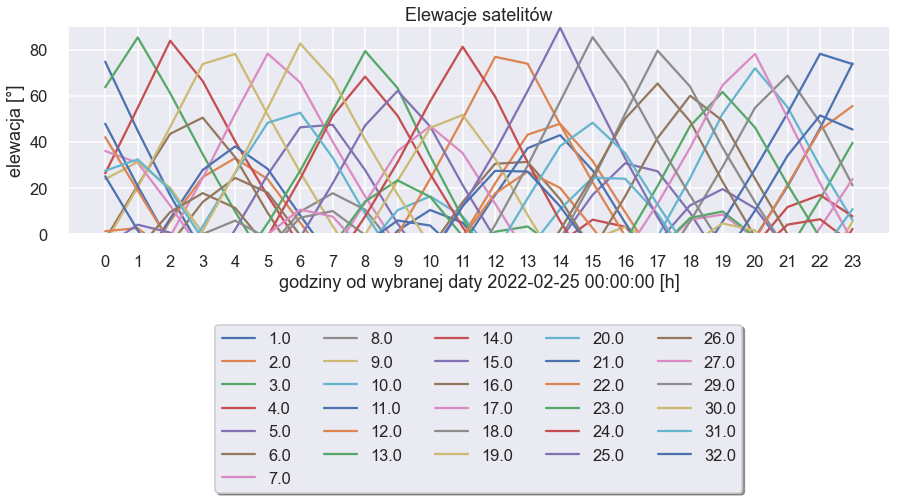

In [532]:
sns.set_theme(context='talk', style='darkgrid')  # style=ticks white 
for k, v in elewacje2.items():
    plt.plot(v['h'], v['el'], label=k)
    
plt.title('Elewacje satelitów')
plt.ylabel('elewacja [°]')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
ax = plt.gca()
ax.set_ylim([0, 90])
# Legenda do wywalenia raczej
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [533]:
numeryy = []
godzinyy = []
elewacjee = []
for prn, v in elewacje2.items():
    godzinyy.extend(v['h'])
    elewacjee.extend(v['el'])
    for i in range(len(v['h'])):
        numeryy.append(prn)
eledf = pd.DataFrame(list(zip(numeryy, godzinyy, elewacjee)), columns=['PRN', 'h', 'el'])

In [534]:
fig = px.line(eledf, x='h', y='el', color='PRN',title='Elewacje satewlitów', labels={'h':'godzina od wybranej daty','el':'elewacja [°]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.update_xaxes(showspikes=True)
# fig.update_yaxes(showspikes=True)
fig.show()

## Liczba widocznych satelitów

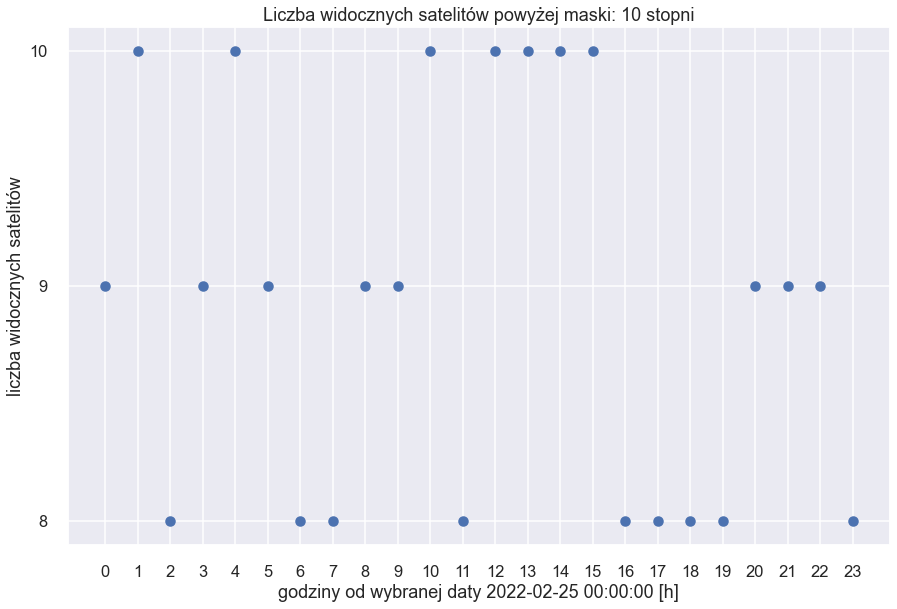

In [535]:
plt.scatter(range(0,24),ile_widocznych)   
plt.title('Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni')
plt.ylabel('liczba widocznych satelitów')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(min(ile_widocznych),max(ile_widocznych)+1))
plt.tight_layout()
plt.show()

In [536]:
iledf = pd.DataFrame(list(zip(ile_widocznych, godzinyy)), columns=['ile', 'h'])
# iledf

In [537]:
fig = px.scatter(iledf, x='h', y='ile', title='Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni', labels={'h':'godzina od wybranej daty','ile':'liczba widocznych satelitów'}, template='plotly_dark')
fig.update_traces(marker=dict(color='blue',opacity=1,size=14,
                              line=dict(width=2,
                                        color='lightblue')))
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1),
                 yaxis=dict(tickmode='linear', tick0=min(ile_widocznych), dtick=1))

fig.show()

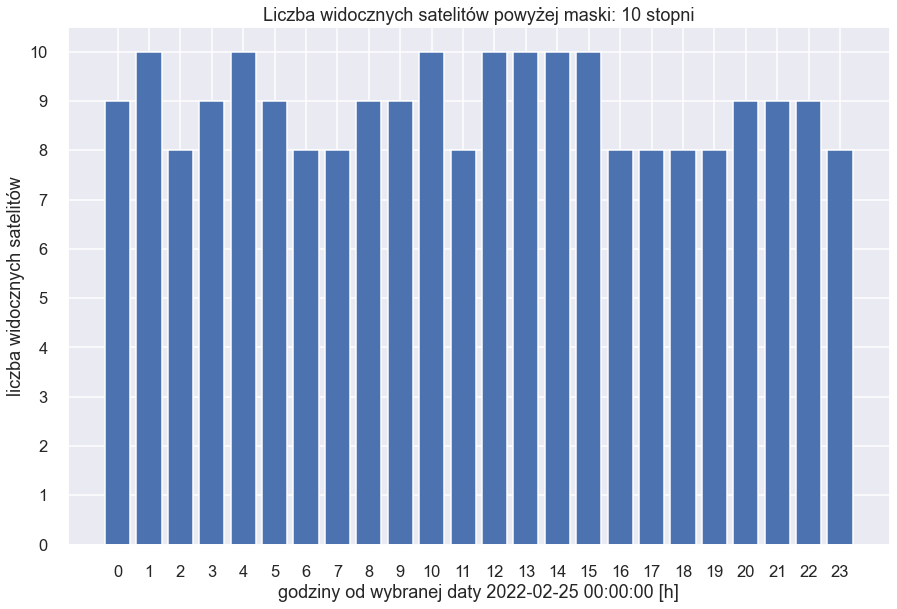

In [538]:
plt.bar(range(0,24),ile_widocznych)
plt.title('Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni')
plt.ylabel('liczba widocznych satelitów')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(0,max(ile_widocznych)+1))
plt.tight_layout()
plt.show()

## Współczynniki DOP

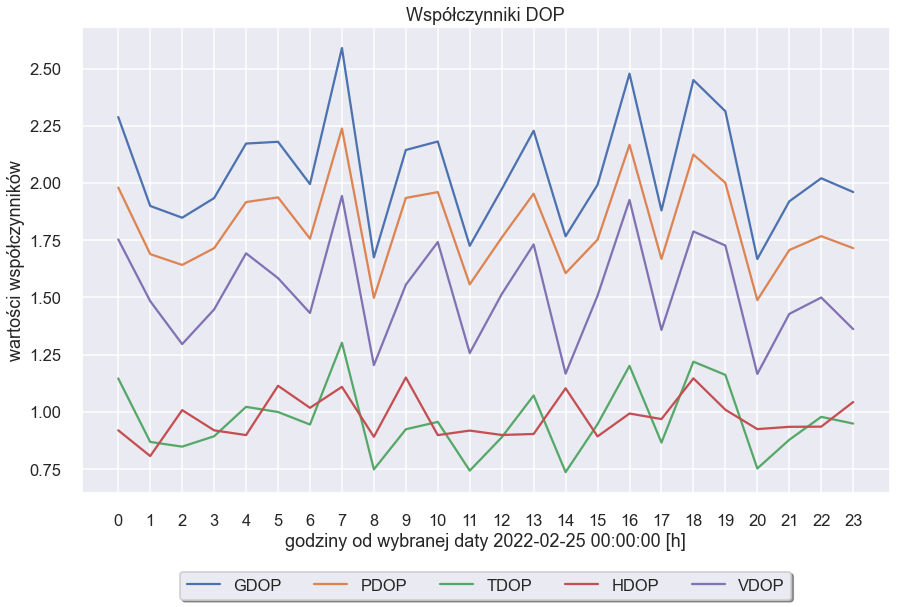

In [539]:
for k, v in DOP.items():
    plt.plot(range(0,24), v, label=k)
    
plt.title('Współczynniki DOP')
plt.ylabel('wartości współczynników')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [540]:
dopdf = pd.DataFrame(list(zip(godzinyy, DOP['GDOP'], DOP['PDOP'], DOP['TDOP'], DOP['HDOP'], DOP['VDOP'])), columns=['h', 'GDOP', 'PDOP', 'TDOP', 'HDOP', 'VDOP'])

In [541]:
fig = px.line(dopdf, x='h', y=['GDOP', 'PDOP', 'TDOP', 'HDOP', 'VDOP'], title='Współczynniki DOP', labels={'h':'godzina od wybranej daty'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.show()

## Wyszczególnienie widocznych satelitów

In [542]:
godzinyyy = []
numeryyy = []
useless = []
for k, v in jakie_widoczne.items():
    for i in range(len(v)):
        godzinyyy.append(k)
        useless.append(1)
    numeryyy.extend(v)

In [543]:
jakiedf = pd.DataFrame(list(zip(godzinyyy, numeryyy, useless)), columns=['h', 'PRN', 'widoczne'])

In [544]:
jakiedf["PRN"] = jakiedf["PRN"].astype(str)
fig = px.bar(jakiedf, x="h", y="widoczne", color="PRN", title="Wyszczególnienie widocznych satelitów", labels={'widoczne':'liczba widocznych satelitów','h':'godzina od wybranej daty'})
fig.show()

## Skyplot

In [545]:
# print(sorted(satelity_elaz))  # [NR, EL, AZ]

In [546]:
# plot_skyplot(satelity_elaz)

## Groundtrack

In [547]:
print(satelity_neu)

{1.0: [[-5246841.918266001, 1042778.3253596826, 19579972.31241733], [-14779139.995629763, 4540431.079613047, 15330647.375856116], [-22533546.163909372, 5536614.042197178, 6978967.6724453075], [19471052.131955512, 14009407.208167689, 4385431.875957597], [3813119.687748989, -21500941.001571074, 8229498.267860861], [5723268.906141844, -13713054.266705606, 15307001.138235342], [2157851.5971987573, -5147224.726407247, 19401388.109128114]], 3.0: [[682171.9925742261, -9134458.459162064, 18457950.875425063], [1523269.4022616744, 685531.5142477853, 20065908.841220364], [-2758223.106523579, 9682044.115608372, 18175444.8261633], [-10238064.361748155, 15380553.743282616, 12733131.38392161], [-11545804.547764812, -20210078.280715287, 6262791.890947872], [-4282354.216655354, -16376196.959966877, 13969408.809898986]], 4.0: [[-18834648.69735769, -8735019.744685955, 10248910.745639142], [-10459450.977667458, -6302923.931696653, 17256943.446837265], [-2088147.476658281, -655611.3893656363, 20126744.1133

## Testy

In [548]:
wybrany_nr = int(input('Wpisz numer satelity do wyświetlenia:'))

Wpisz numer satelity do wyświetlenia:1


In [549]:
print(satelity_neu[1])

[[-5246841.918266001, 1042778.3253596826, 19579972.31241733], [-14779139.995629763, 4540431.079613047, 15330647.375856116], [-22533546.163909372, 5536614.042197178, 6978967.6724453075], [19471052.131955512, 14009407.208167689, 4385431.875957597], [3813119.687748989, -21500941.001571074, 8229498.267860861], [5723268.906141844, -13713054.266705606, 15307001.138235342], [2157851.5971987573, -5147224.726407247, 19401388.109128114]]


In [550]:
n=[]
e=[]
u=[]
for lista in satelity_neu[wybrany_nr]:
#     print(lista)
    n.append(lista[0])
    e.append(lista[1])
    u.append(lista[2])

In [551]:
neudf = pd.DataFrame(list(zip(n, e, u)), columns=['n', 'e', 'u'])
neudf

,n,e,u
0,-5.246842e+06,1.042778e+06,1.957997e+07
1,-1.477914e+07,4.540431e+06,1.533065e+07
2,-2.253355e+07,5.536614e+06,6.978968e+06
3,1.947105e+07,1.400941e+07,4.385432e+06
4,3.813120e+06,-2.150094e+07,8.229498e+06
5,5.723269e+06,-1.371305e+07,1.530700e+07
6,2.157852e+06,-5.147225e+06,1.940139e+07


In [552]:
fig = px.scatter_3d(neudf, y='n', x='e', z='u')  # , color=main_df['u']>0, labels={"color": "u > 0"}

# plotly.offline.plot(fig, filename='neu.html', auto_open=False)  # save as html

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0}, scene_aspectmode='data')  # , scene_aspectmode='data'
fig.show()